## Import Packages

In [1]:
from matplotlib import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import xgboost as xgb
from Helper_Functions import degree_search
from Helper_Functions import polynomial_search
from joblib import dump, load
import json
import statsmodels.api as sm

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Read Training Data

In [30]:
training = pd.read_csv("Data/train.csv")

## Data Cleaning

## Datetime Object Breakdown

In [31]:
training["date"] = training.datetime.apply(lambda x : x.split()[0])
training["hour"] = training.datetime.apply(lambda x : x.split()[1].split(":")[0])
training["weekday"] = training.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
training["month"] = training.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])


## Categorical Type Creation

In [32]:
# Mapping to strings
training["season"] = training.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
training["weather"] = training.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

# Mapping to categories

categoryVariables = ["season","weather", "weekday", "month"]
textCategories = ["season","weather", "weekday", 'month']
alreadyCategories = ["holiday", "workingday"]
binVariables = ["hour"]


for var in categoryVariables:
    training[var] = training[var].astype("category")

In [33]:
numericVariables = ['atemp', 'humidity', 'windspeed']

In [34]:
training.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'hour', 'weekday', 'month'],
      dtype='object')

## Exploratory Data Analysis

## Missing Value Analysis

<AxesSubplot:>

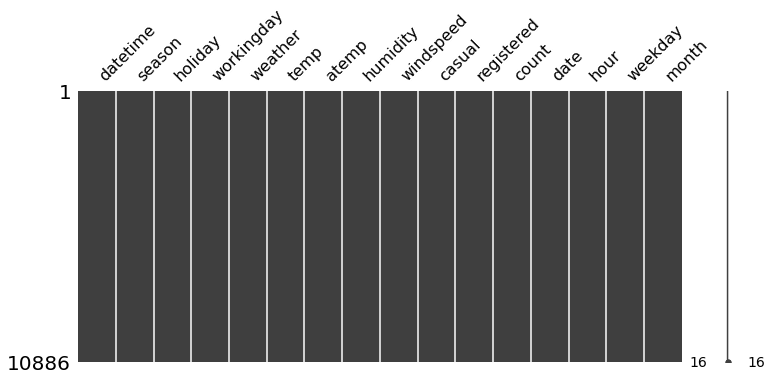

In [35]:
msno.matrix(training,figsize=(12,5))

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

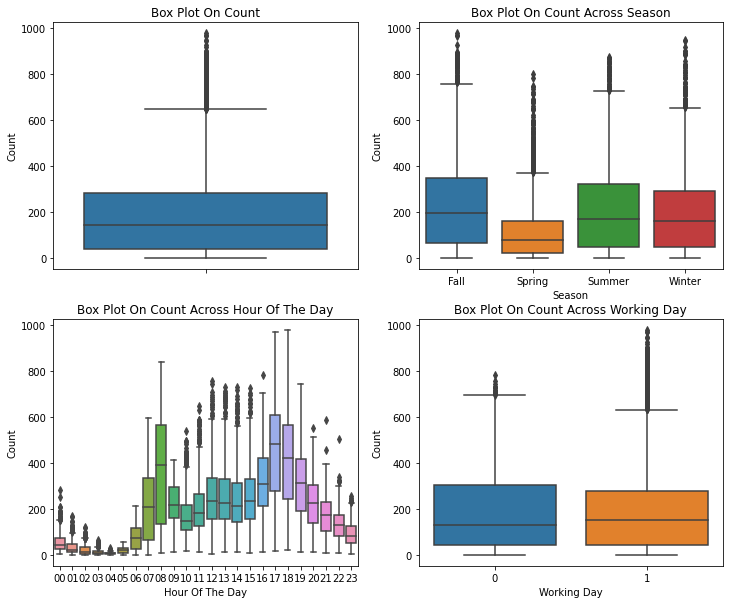

In [36]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=training,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=training,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=training,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=training,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

## Outlier Removal

In [37]:
# Remove data greater than 4 std away from mean

# numeric_cols = ["temp","atemp","humidity","windspeed","casual","registered","count"]

# print("before outlier removal, " + str(training.shape[0]) + " rows")

# for col in numeric_cols:
#     training = training[np.abs(training[col]-training[col].mean())<=(4*training[col].std())] 
    
# print("after outlier removal, " + str(training.shape[0]) + " rows")

## Get Dummies & Bins

In [38]:
# Unrepeatable
bins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')
training[binVariables] = bins.fit_transform(training[binVariables])
training[binVariables] = training[binVariables].astype("category")

In [39]:
pd.get_dummies(training[textCategories+binVariables], drop_first=True)

,season_Spring,season_Summer,season_Winter,"weather_ Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog","weather_ Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","weather_ Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,...,month_March,month_May,month_November,month_October,month_September,hour_1.0,hour_2.0,hour_3.0,hour_4.0,hour_5.0
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10882,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10883,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10884,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
dummie_cols = pd.get_dummies(training[textCategories+binVariables+['month']]).columns
training = training.join(pd.get_dummies(training[textCategories+binVariables+['month']]))

## Numeric Feature Scaling - especially for SVM

In [42]:
# scaler = StandardScaler()
# training['humidity'] = scaler.fit_transform(training[['humidity']])
# training['atemp'] = scaler.fit_transform(training[['atemp']])

In [43]:
training.to_csv('cleaned_with_dummies.csv')

In [45]:
training.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'hour', 'weekday', 'month', 'season_Fall', 'season_Spring',
       'season_Summer', 'season_Winter',
       'weather_ Clear + Few clouds + Partly cloudy + Partly cloudy',
       'weather_ Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog ',
       'weather_ Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'weather_ Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ',
       'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September', 'hour_0.0', 'hour_1.0', 'hour_

## Treatment effect of Season

In [44]:
X = sm.add_constant(training[['season_Spring', 'season_Summer', 'season_Winter']])
y = training['count']
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     236.9
Date:                Sun, 10 Oct 2021   Prob (F-statistic):          6.16e-149
Time:                        16:10:40   Log-Likelihood:                -71701.
No. Observations:               10886   AIC:                         1.434e+05
Df Residuals:                   10882   BIC:                         1.434e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           234.4171      3.358     69.818

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Treatment effect of Temperature

In [104]:
X = sm.add_constant(training[['temp']])
y = training['casual']
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     3037.
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:26:51   Log-Likelihood:                -56684.
No. Observations:               10886   AIC:                         1.134e+05
Df Residuals:                   10884   BIC:                         1.134e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.5710      1.178    -20.855      0.0

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Omitted Variables - Rainfall

In [49]:
# We test the feasibility of Rainfall by looking at humidity

## Adding humidity to the model: the hypothesis here is that it should reduce the coef on winter and increase the coef on seasons with less holidays
X = sm.add_constant(training[['season_Spring', 'season_Summer', 'season_Winter', 'humidity']])
y = training['count']
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     648.0
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:26:23   Log-Likelihood:                -70883.
No. Observations:               10886   AIC:                         1.418e+05
Df Residuals:                   10881   BIC:                         1.418e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -161.1690      9.916    -16.254

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [99]:
training.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'hour', 'weekday', 'month', 'season_Fall', 'season_Spring',
       'season_Summer', 'season_Winter',
       'weather_ Clear + Few clouds + Partly cloudy + Partly cloudy',
       'weather_ Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog ',
       'weather_ Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'weather_ Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ',
       'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September', 'hour_0.0', 'hour_1.0', 'hour_

In [103]:
from statsmodels.sandbox.regression.gmm import IV2SLS
X = sm.add_constant(training['temp'])
y = training['casual']
ins = training[['season_Fall', 'season_Summer', 'season_Spring', 'windspeed']]
est = IV2SLS(y, X, ins)
est2 = est.fit()
print(est2.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                 casual   R-squared:                       0.203
Model:                         IV2SLS   Adj. R-squared:                  0.203
Method:                     Two Stage   F-statistic:                     943.8
                        Least Squares   Prob (F-statistic):          7.81e-199
Date:                Sun, 10 Oct 2021                                         
Time:                        19:26:26                                         
No. Observations:               10886                                         
Df Residuals:                   10884                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8419      1.601     -4.898      0.0

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [78]:
from statsmodels.sandbox.regression.gmm import IV2SLS
# X = sm.add_constant(training[['season_Spring', 'season_Summer', 'season_Winter']])
X = sm.add_constant(training['atemp'])

y = training['casual']
# ins = training[['atemp']]
ins = training[['windspeed', 'humidity']]

est = IV2SLS(y, X, ins)
est2 = est.fit()
print(est2.summary())

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


LinAlgError: Singular matrix

## Regression discontinuity with humidity and temperature

### Count vs humidity

<AxesSubplot:title={'center':'count'}, xlabel='binedgeshumidity'>

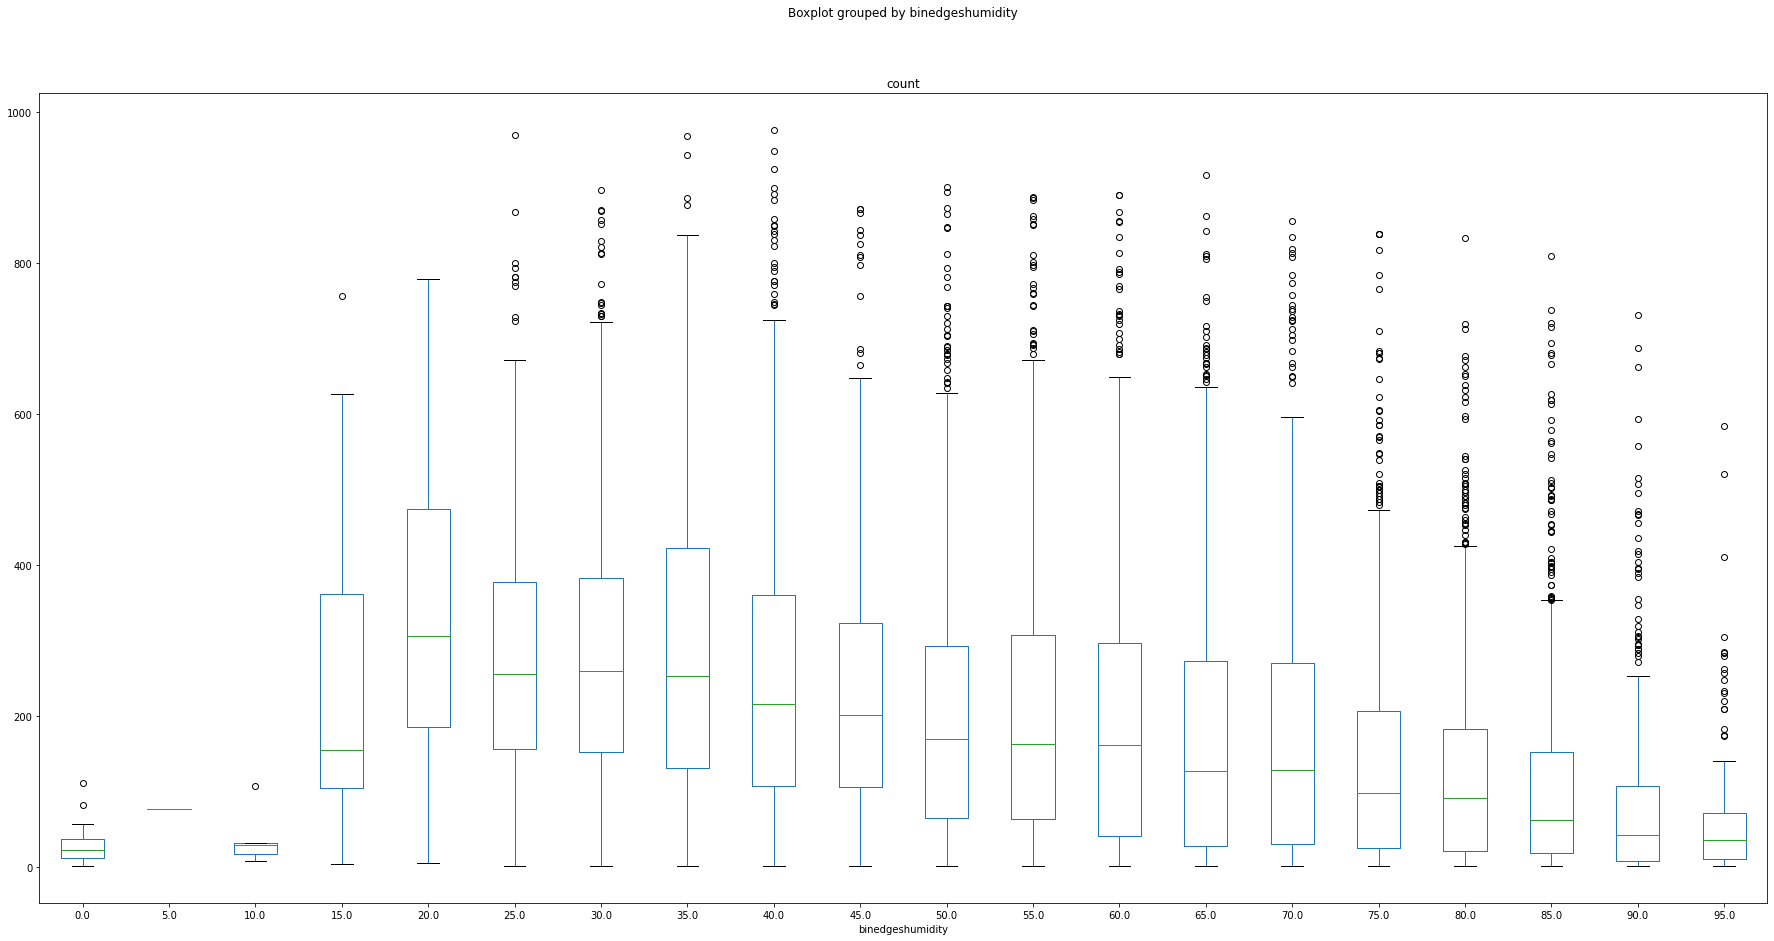

In [221]:
# Using month as the running variable and
# plt.plot(training['atemp'], training['count'])
bins = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
training['binhumidity'] = bins.fit_transform(training[['humidity']])
mapping = {}
for i in range(len(bins.bin_edges_[0])):
    mapping[i] = round(bins.bin_edges_[0][i], 2)
training['binedgeshumidity'] = training['binhumidity'].map(mapping)


training.boxplot(by='binedgeshumidity',column='count', figsize=(30,15), grid=False)

# humidity cutoff point for 100 rentals: <=10 or >=90

### count vs temperature

<AxesSubplot:title={'center':'count'}, xlabel='binedges'>

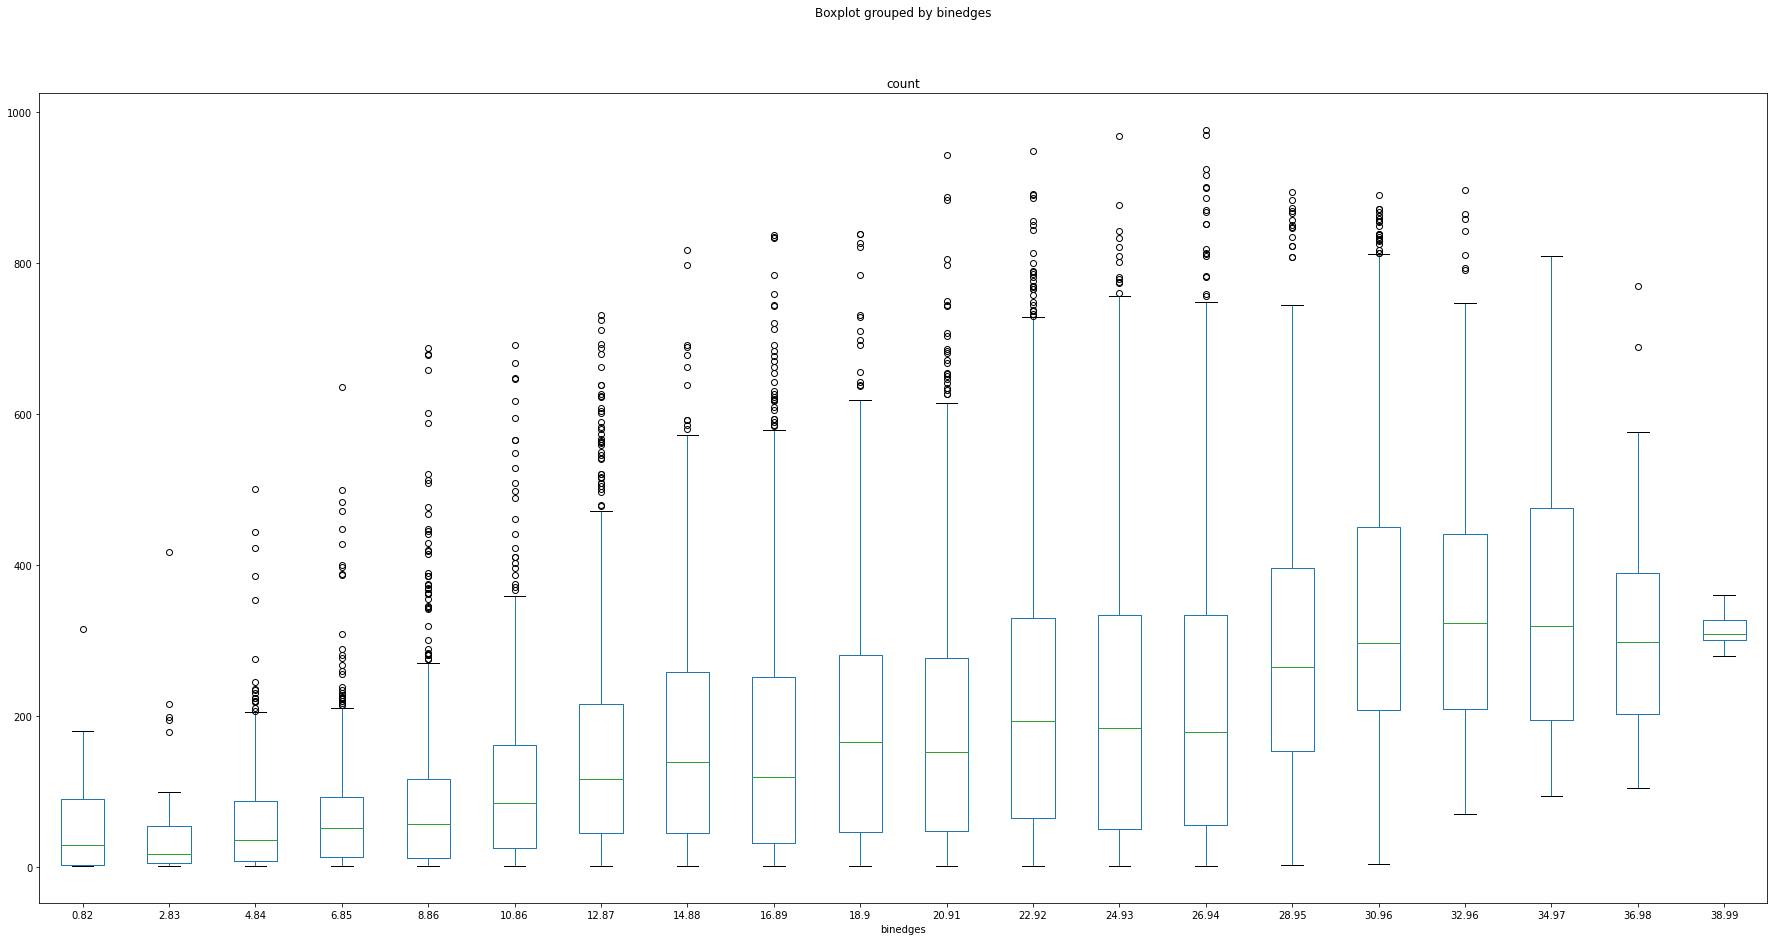

In [222]:
# Using month as the running variable and
# plt.plot(training['atemp'], training['count'])
bins = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
training['bintemp'] = bins.fit_transform(training[['temp']])
mapping = {}
for i in range(len(bins.bin_edges_[0])):
    mapping[i] = round(bins.bin_edges_[0][i], 2)
training['binedges'] = training['bintemp'].map(mapping)


training.boxplot(by='binedges',column='count', figsize=(30,15), grid=False)
## temperature cutoff point: <10.86 degrees celcius

### Count vs extreme weathers

<AxesSubplot:title={'center':'count'}, xlabel='weather'>

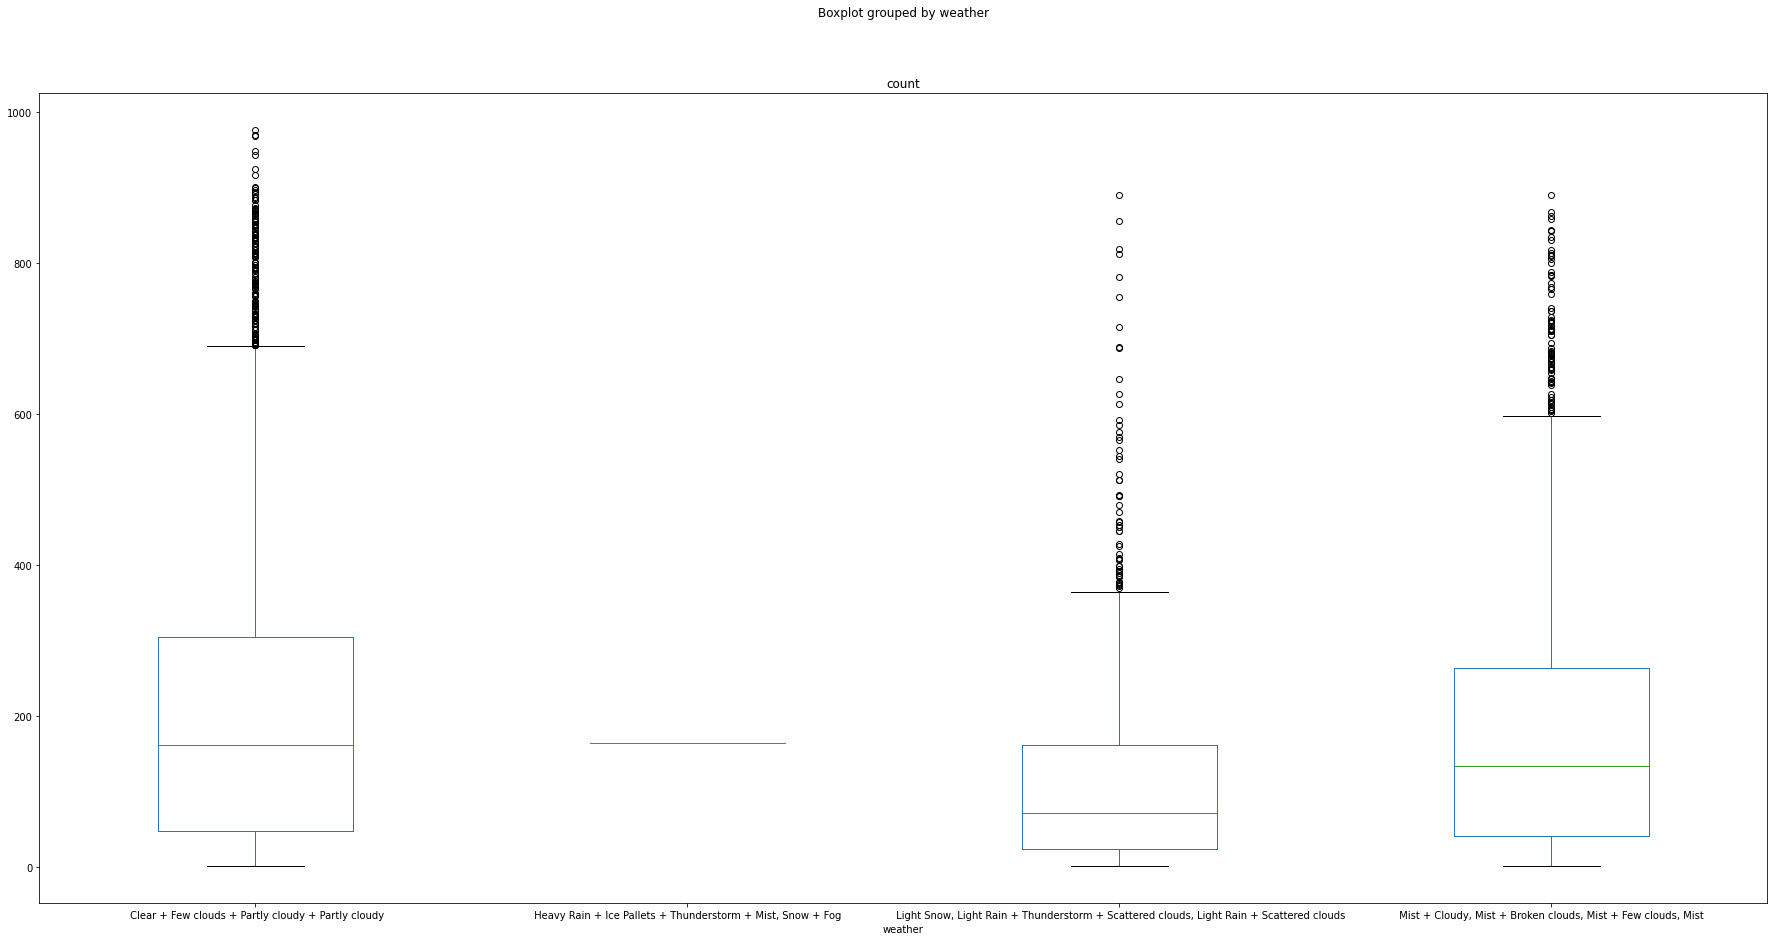

In [223]:
training.boxplot(by='weather',column='count', figsize=(30,15), grid=False)

### Create the discontinuity dummy

In [224]:
#
training['bad_temp_humidity'] = ((training['temp'] <= 10.86) | ((training['humidity'] < 10) | (training['humidity'] > 90))).astype(int)
training['bad_temp_humidity'].value_counts()


0    8704
1    2182
Name: bad_temp_humidity, dtype: int64

In [256]:
training['temp'].dtype

dtype('float64')

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     2006.
Date:                Sat, 09 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:37:50   Log-Likelihood:                -71125.
No. Observations:               10886   AIC:                         1.423e+05
Df Residuals:                   10884   BIC:                         1.423e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0462      4.439      1.362      0.1

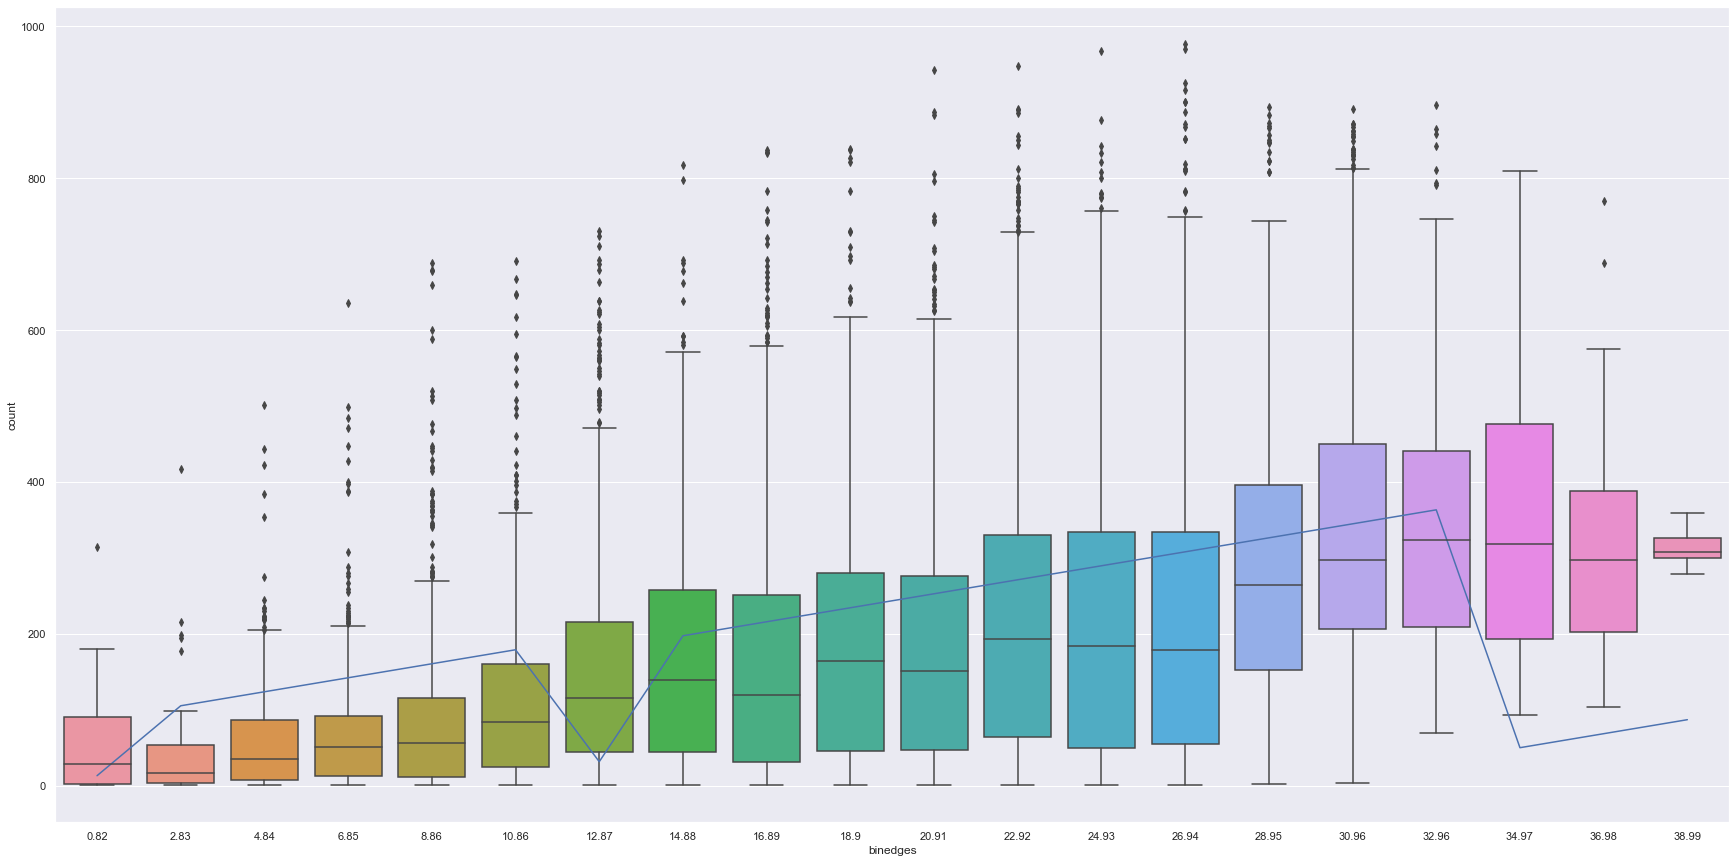

In [270]:
import seaborn as sns
sns.set(rc={'figure.figsize':(30,15)})
### Treatment effect of month with bad weather as discontinuity
# X = sm.add_constant(training[[col for col in training.columns if 'month_' in col and 'January' not in col]])
# y = training['count']
# est = sm.OLS(y, X)
# est2 = est.fit()
# print(est2.summary())

bedges = sorted(list(set(training['binedges'])))
lr = LinearRegression().fit(X=np.array(training['temp']).reshape(-1,1), y=training['count'])
pred = lr.predict(np.array(bedges).reshape(-1, 1))
pred

X = sm.add_constant(training[['temp']])
y = training['count']
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

training['binedges'] = training['binedges'].astype(float)
p1=sns.boxplot(x='binedges', y='count', data=training)

p2=sns.lineplot(x=bedges, y=pred)
plt.show()
# training.boxplot(by='month',column='count', figsize=(30,15), grid=False, positions=)
#4,3,7,0,8,6,5,1,11,10,9,2

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     78.48
Date:                Sat, 09 Oct 2021   Prob (F-statistic):          3.97e-171
Time:                        17:50:50   Log-Likelihood:                -71630.
No. Observations:               10886   AIC:                         1.433e+05
Df Residuals:                   10874   BIC:                         1.434e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              90.3665      5.867     

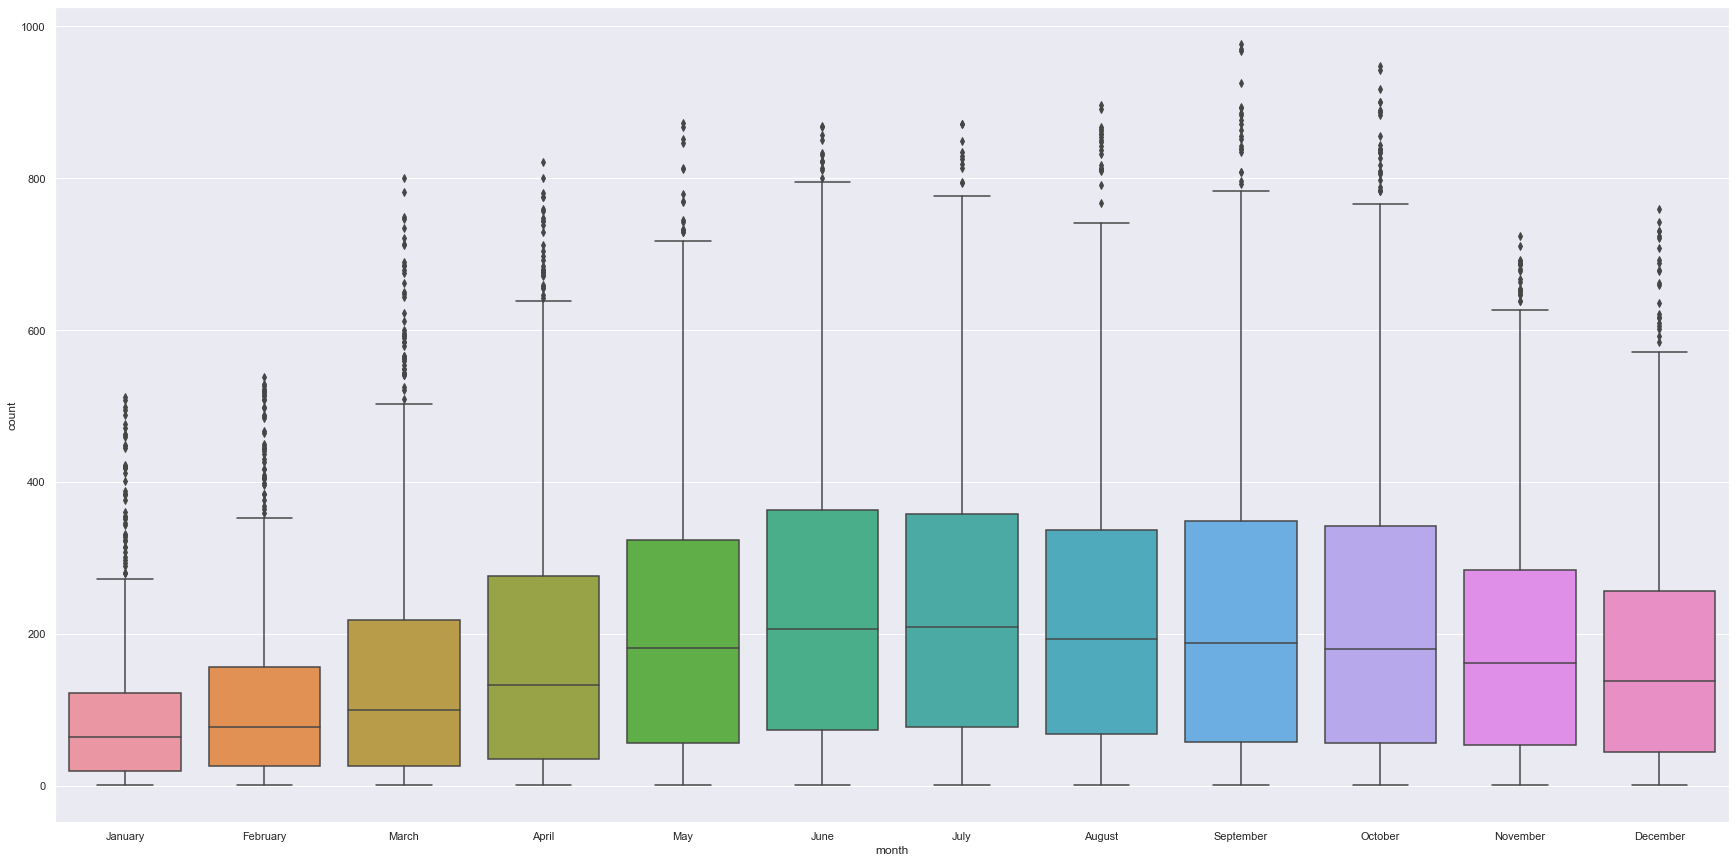

In [274]:
import seaborn as sns
sns.set(rc={'figure.figsize':(30,15)})
### Treatment effect of month with bad weather as discontinuity
X = sm.add_constant(training[[col for col in training.columns if 'month_' in col and 'January' not in col]])
y = training['count']
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

p1=sns.boxplot(x='month', y='count', data=training, order=['January', 'February', 'March', 'April', 'May', 'June',
                                                                                   'July', 'August', 'September', 'October', 'November',
                                                                                   'December'])

# p2=sns.regplot(x='temp', y='count', data=training)
# plt.show()
# training.boxplot(by='month',column='count', figsize=(30,15), grid=False, positions=)
#4,3,7,0,8,6,5,1,11,10,9,2

## Choosing Atemp as instrument variable

### test for instrument relevance

In [46]:
X = sm.add_constant(training[['temp']])
y = training['count']
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1950.
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:18:19   Log-Likelihood:                -71149.
No. Observations:               10886   AIC:                         1.423e+05
Df Residuals:                   10884   BIC:                         1.423e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5114      4.741     -1.162      0.2

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### test for 

In [125]:
bins.bin_edges_[0][0]

0.82

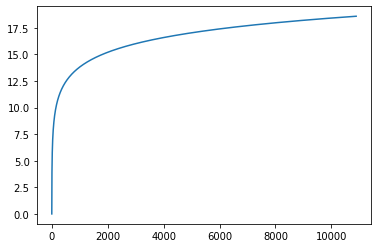

In [65]:
plt.plot(list(training.index), training.logindexsquared)
# from math import log
# training['logindexsquared'] = np.log(np.square(np.array(training.index)))
# training.logindexsquared

## Generate Polynomial Features for Numeric Variables

In [21]:
poly = PolynomialFeatures(1)
X = poly.fit_transform(X)

X.shape

(10212, 28)

## Feature Selection - Variance Thresholding

In [22]:
sel = VarianceThreshold(threshold=(.91 * (1 - .91)))
X = sel.fit_transform(X)

## Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=1)

## Linear Regression

In [24]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

lreg.score(X_test, y_test)

predictions = lreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=lreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.6000616542943236; 
RMSLE: 1.1218114933841408


## Support Vector Regression

In [25]:
svreg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svreg.fit(X_train, y_train)

svreg.score(X_test, y_test)

predictions = svreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=svreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.47372945595960836; 
RMSLE: 0.920995028926754


## Random Forest Regressor

In [26]:
rfreg = RandomForestRegressor(max_depth=2, random_state=0)
rfreg.fit(X_train, y_train)

rfreg.score(X_test, y_test)

predictions = rfreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=rfreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.40298838131365877; 
RMSLE: 0.9846269896902523


## Hyperparameter Tuning

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Training with random_grid

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


ar = rf_random.score(X_test, y_test)

predictions = rf_random.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Adjusted R squared: 0.7654076095351909; 
RMSLE: 0.7295152585067554


## Gradient Boosting Regressor

In [27]:
gbreg = GradientBoostingRegressor(random_state=0)
gbreg.fit(X_train, y_train)

gbreg.score(X_test, y_test)

predictions = gbreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=gbreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.70964494721279; 
RMSLE: 0.8593992114720207


In [51]:
# Number of trees in gbm
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Training with random_grid

gb = GradientBoostingRegressor(random_state=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)


ar = gb_random.score(X_test, y_test)

predictions = gb_random.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Adjusted R squared: 0.7464923334328224; 
RMSLE: 0.8124874226668816


## Hyperparameter Tuning

## XGBoost

In [49]:
train_data = xgb.DMatrix(X_train, y_train)
test_data = xgb.DMatrix(X_test, y_test)

params = {"booster": 'gbtree',
              "objective" : "reg:squaredlogerror",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": 500,
              "max_depth" : 5,
              "reg_alpha" : 0.01,
              "reg_lambda" : 0.01,
              "gamma": 5,
              "num_threads" : 20,
              "min_child_weight" : 5,
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": 500}



cv_result = xgb.cv(params,
                   train_data,
                   1000,
                   early_stopping_rounds=100,
                   stratified=True,
                   nfold=3)

xgboost = xgb.train(params, train_data, 10000)

predictions = xgboost.predict(test_data)

ar = r2_score(y_test,np.maximum(predictions, 0))




txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


Adjusted R squared: -0.456659658612641; 
RMSLE: 1.2331838380955185


## Save Model

In [28]:
dump(rf_random, 'Models/randomForestEnsemble.joblib') 

## Generate Kaggle Predictions

In [29]:
test_data = pd.read_csv('Data/test.csv')



test_data["date"] = test_data.datetime.apply(lambda x : x.split()[0])
test_data["hour"] = test_data.datetime.apply(lambda x : x.split()[1].split(":")[0])
test_data["weekday"] = test_data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
test_data["month"] = test_data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])


# Mapping to strings
test_data["season"] = test_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
test_data["weather"] = test_data.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })





# Mapping to categories

categoryVariables = ["season","weather", "weekday"]
textCategories = ["season","weather", "weekday"]
alreadyCategories = ["holiday", "workingday"]
binVariables = ["hour"]


for var in categoryVariables:
    test_data[var] = test_data[var].astype("category")
    
    
    
# Unrepeatable
bins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='uniform')
test_data[binVariables] = bins.fit_transform(test_data[binVariables])
test_data[binVariables] = test_data[binVariables].astype("category")


dummie_cols = pd.get_dummies(test_data[textCategories+binVariables]).columns
test_data = test_data.join(pd.get_dummies(test_data[textCategories+binVariables]))

X = test_data[numericVariables+list(dummie_cols)+alreadyCategories]


X = poly.transform(X)
X = sel.transform(X)

test_data['count'] = rf_random.predict(X)

test_data.to_csv('Data/test_labelled.csv')

In [33]:
test_data[['datetime', 'count']].to_csv('Data/test_submission.csv', index=False)

In [32]:
test_data[['datetime', 'count']]

,datetime,count
0,2011-01-20 00:00:00,11.100054
1,2011-01-20 01:00:00,9.296056
2,2011-01-20 02:00:00,9.296056
3,2011-01-20 03:00:00,10.096431
4,2011-01-20 04:00:00,30.691040
...,...,...
6488,2012-12-31 19:00:00,206.653003
6489,2012-12-31 20:00:00,75.687563
6490,2012-12-31 21:00:00,64.693039
6491,2012-12-31 22:00:00,56.792829
